# Algorithms and Big Data in Chemistry and Materials
## Hometask 3

For this task, you should use the dataset from the first homework. 

Your dataset must contain at least 1000 descriptors, excluding the target ("raw_value"), and all the data cleansing steps must have been completed.

Your task:

1. Choose one clustering algorithm suitable for your data and motivate your choice. Apply it, visualize and interpret your results. 

2. Apply automated feature engineering algorithms to your data. Select the most relevant features using common sense and domain knowledge, and motivate your choice.

3. Implement automated feature selection in the context of a machine learning problem of your choice. You are expected to use molecular descriptors as feature vectors and any molecular property as a target variable. Visualize and interpret your results on selected features and their importance.

Complete all the steps of the assignment in a Jupyter Notebook (one per team).
Upload the finalized Jupyter Notebook to the Google Drive of the course or to GitHub.

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install kneed
%pip install autofeat
!pip install sklearn-genetic

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from kneed import KneeLocator
import umap
from autofeat.autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import RandomForestRegressor

c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Working with data

In [3]:
#Reading a file
df = pd.read_excel('df_afterhw1.xlsx')
df

,Unnamed: 0.1,Unnamed: 0,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,10.1016/j.materresbull.2017.08.038,8/25/2017,Materials Research Bulletin,CDCL2TREATMENTCONCENTRATIONEVOLUTIONPHYSICALPR...,CdCl2,0.0,NaN,el_cde_tables,...,0.000000,3.000000,183.841064,61.280355,300000000,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
1,1,1108,10.1016/j.materresbull.2017.08.038,8/25/2017,Materials Research Bulletin,CDCL2TREATMENTCONCENTRATIONEVOLUTIONPHYSICALPR...,CdCl2,0.0,NaN,el_mylogic,...,0.000000,3.000000,183.841064,61.280355,300000000,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
2,2,1403,10.1016/j.ijleo.2018.01.112,1/31/2018,Optik,EFFECTCDCL2HEATTREATMENTINARO2ATMOSPHERESTRUCT...,CdCl2,0.0,0 nm,el_mylogic,...,0.000000,3.000000,183.841064,61.280355,300000000,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
3,3,2813,10.1016/j.ijleo.2018.01.112,1/31/2018,Optik,EFFECTCDCL2HEATTREATMENTINARO2ATMOSPHERESTRUCT...,CdCl2,0.0,NaN,el_cde_tables,...,0.000000,3.000000,183.841064,61.280355,300000000,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
4,4,1,10.1016/S0021-9797(03)00199-1,4/26/2003,Journal of Colloid and Interface Science,EVALUATIONDLVOTHEORYDISJOININGPRESSUREFILMCOND...,Dodecanol,0.0,NaN,el_mylogic,...,7.826044,40.245095,186.198365,4.774317,364,10,46,44,4.75,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,3357,4961,10.1016/j.jct.2015.08.021,8/24/2015,The Journal of Chemical Thermodynamics,STUDYINTERMOLECULARINTERACTIONSTHROUGHDIELECTR...,Amyl alcohol,0.0,NaN,el_cde_tables,...,6.608001,28.105124,88.088815,4.893823,35,3,18,16,3,1.750000
3358,3358,4964,10.1016/j.gca.2014.04.009,4/18/2014,Geochimica et Cosmochimica Acta,SILICATESPECIATIONINH2ONA2OSIO2FLUIDS340MOLSIO...,zircon,0.0,NaN,el_mylogic,...,7.625107,30.418928,181.861289,30.310215,500000016,0,20,16,divide by zero encountered in power (mZagreb1),1.000000
3359,3359,4970,10.1016/j.ophtha.2013.01.005,2/8/2013,Ophthalmology,ORALDOCOSAHEXAENOICACIDINPREVENTIONEXUDATIVEAG...,DHA,0.0,NaN,el_cde_tables,...,8.665096,54.967726,328.240230,5.861433,2279,21,92,90,8.111111,6.083333
3360,3360,4976,10.1016/j.opelre.2019.01.001,3/19/2019,Opto-Electronics Review,AREVIEWPROGRESSZNSEINORGANICSCINTILLATOR,Li(Eu),0.0,NaN,el_cde_tables,...,1.098612,7.493061,159.937235,79.968617,1,0,2,1,2,1.000000


### 0.1. Deleting Repetitions
Many individual connections are repeated in the dataset, so we will remove them and replace the values with averages with the std condition, in cases where std is large, we will first remove the outliers, and then replace them with the average

In [5]:
# Grouping and calculating the number, average and standard deviation of duplicate cells
repeat_df = df[['SMILES', 'Refractive_index']].groupby(['SMILES']).agg(['count', 'mean', 'std'])
repeat_df.columns = ['_'.join(col).rstrip('_') for col in repeat_df.columns.values] #Names for new columns
repeat_df = repeat_df[repeat_df['Refractive_index_count'] != 1].sort_values('Refractive_index_count', ascending = False) #Sort in descending order
repeat_df

,Refractive_index_count,Refractive_index_mean,Refractive_index_std
SMILES,,,
O=[Si]=O,174,1.477565,0.256143
CCO,164,1.449367,0.329269
O=[Ti]=O,129,2.284182,0.410611
CO,86,1.407751,0.295800
[SiH4],72,2.671554,0.966801
...,...,...,...
ICI,2,1.740500,0.000707
NC(CO)(CO)CO,2,1.331000,0.001414
NC1=Nc2nc[nH]c2C(=O)N1,2,1.365000,0.077782


Since there is a rather large deviation for all cases and it is impossible to view it, let's take the median value for all cases

In [6]:
# Updated repeat_df
repeat_df = df[['SMILES', 'Refractive_index']].groupby(['SMILES']).agg('median')
repeat_df


,Refractive_index
SMILES,
BN,1.65800
BO,1.49000
BPCC,1.50700
BSB,2.52000
B[V],2.09500
...,...
c1ccncc1,1.50950
o1cccc1,1.44400
s1cccc1,1.42465


In [7]:
# Adding information to the main table
df = pd.merge(df, repeat_df, on='SMILES')
# Удаление дублирующихся строк, оставляем только первое вхождение, с учетом определенных столбцов
df = df.drop_duplicates(keep='first', subset=['SMILES', 'Refractive_index_y'])
df

,Unnamed: 0.1,Unnamed: 0,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Refractive_index_y
0,0,0,10.1016/j.materresbull.2017.08.038,8/25/2017,Materials Research Bulletin,CDCL2TREATMENTCONCENTRATIONEVOLUTIONPHYSICALPR...,CdCl2,0.0,NaN,el_cde_tables,...,3.000000,183.841064,61.280355,300000000,0,0,0,divide by zero encountered in power (mZagreb1),0.000000,2.2950
4,4,1,10.1016/S0021-9797(03)00199-1,4/26/2003,Journal of Colloid and Interface Science,EVALUATIONDLVOTHEORYDISJOININGPRESSUREFILMCOND...,Dodecanol,0.0,NaN,el_mylogic,...,40.245095,186.198365,4.774317,364,10,46,44,4.75,3.500000,1.4355
6,5,2,10.1016/S0030-4018(00)01152-4,2/9/2001,Optics Communications,DISPERSIONOPTICALCONSTANTSQUARTZPOLYMETHYLMETH...,PMMA,0.0,3000 nm,el_mylogic,...,32.688753,101.060255,6.316266,46,6,26,26,4.472222,1.777778,1.4900
63,62,3,10.1016/j.ceramint.2013.06.065,7/2/2013,Ceramics International,EFFECTDIFFERENTSOLVENTSSTRUCTURALOPTICALPROPER...,EtOH,0.0,NaN,el_mylogic,...,17.310771,46.041865,5.115763,4,0,6,4,2.25,1.000000,1.3610
227,84,4,10.1016/j.mssp.2018.06.033,7/4/2018,Materials Science in Semiconductor Processing,VANADIUMPENTOXIDEV2O5ANTIREFLECTIONCOATINGFORG...,silicon,2.0,NaN,el_cde_text,...,1.000000,32.008227,6.401645,0,0,0,0,divide by zero encountered in power (mZagreb1),0.000000,3.4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,3352,4936,10.1039/C1JM13650J,11/8/2011,Journal of Materials Chemistry,"Photoactive lanthanide (Eu 3+ , Tb 3+ ) center...",europium,0.0,NaN,rsc_cde_text,...,1.000000,152.921230,152.921230,0,0,0,0,divide by zero encountered in power (mZagreb1),0.000000,2.0000
3358,3356,4960,10.1016/j.fluid.2014.10.005,10/21/2014,Fluid Phase Equilibria,ACHEMICALSTRUCTUREBASEDMODELFORESTIMATIONREFRA...,Bis(trichlorosilyl)methane,0.0,NaN,el_mylogic,...,37.856472,279.782619,25.434784,88,6,42,40,6.375,1.750000,1.4740
3359,3358,4964,10.1016/j.gca.2014.04.009,4/18/2014,Geochimica et Cosmochimica Acta,SILICATESPECIATIONINH2ONA2OSIO2FLUIDS340MOLSIO...,zircon,0.0,NaN,el_mylogic,...,30.418928,181.861289,30.310215,500000016,0,20,16,divide by zero encountered in power (mZagreb1),1.000000,1.3840
3360,3359,4970,10.1016/j.ophtha.2013.01.005,2/8/2013,Ophthalmology,ORALDOCOSAHEXAENOICACIDINPREVENTIONEXUDATIVEAG...,DHA,0.0,NaN,el_cde_tables,...,54.967726,328.240230,5.861433,2279,21,92,90,8.111111,6.083333,3.0400


In [8]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1','Refractive_index_x'], axis = 1)

### 0.2. Deleting extradescriptors
- Delete the descriptors that do not carry any information (that is, all are equal to one number)
- Let's remove the descriptors in which the expressions stand instead of the numerical value

#### 0.2.1. Let's remove the descriptors in which the expressions stand instead of the numerical value

In [9]:
# Selecting columns of the object type
object_cols = list(df.select_dtypes(include=['object']).columns)
#Let's remove the signs we need from the list
for desc in ['DOI', 'Name', 'SMILES', 'measurement_method', 'Right_DOI', 'IUPACName', 'MolecularFormula', 'IsomericSMILES']:
    print(desc)
    object_cols.remove(desc)
# Deleting columns of the object type
df = df.drop(object_cols, axis=1)
df.shape

DOI
Name
SMILES
measurement_method
Right_DOI
IUPACName
MolecularFormula
IsomericSMILES


(774, 958)

#### 0.2.2. Delete the descriptors that do not carry any information (that is, all are equal to one number)

In [10]:
# calculate the standard deviation of each column
stds = df.std()

# create a list of columns with a zero standard deviation
cols_to_drop = stds[stds == 0].index.tolist()

# delete columns with a standard deviation of zero
df = df.drop(columns=cols_to_drop)
df.shape

C:\Users\iyale\AppData\Local\Temp\ipykernel_5608\2631129552.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stds = df.std()


(774, 820)

In [11]:
#Renaming a column
df.rename(columns = {'Refractive_index_y':'Refractive_index'}, inplace = True )

## 1. Clustering
### 1.1. Сhoosing the number of clusters

In [12]:
# Fill in the gaps with kNN
#using the kNN method to fill in the missing data
# Data
data = df.select_dtypes(include = ['float', 'int'])

# Create a KNNImputer object with the number of nearest neighbors equal to 5
imputer = KNNImputer(n_neighbors=5)

# Fill in the missing values in the dataset
data_imputed = imputer.fit_transform(data)

# Convert a numpy array to a pandas dataframe
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

data_imputed.shape

# Let's normalize the data
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(data_imputed)
df_norm = pd.DataFrame(df_norm, columns=data_imputed.columns)

#Dimension reduction
# Data
X, y = df_norm.drop(["Refractive_index"], axis=1), df_norm[["Refractive_index"]].values.flatten()

# initialize the algorithm of the variety and train on X, y
X_umap = umap.UMAP(n_components=2, min_dist = 0.5, metric = 'euclidean', random_state=989).fit_transform(X)


c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

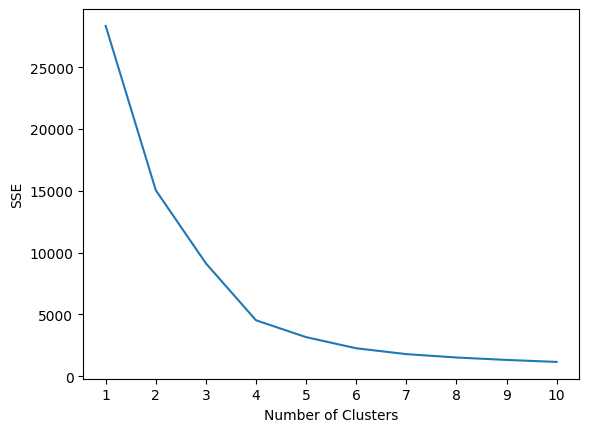

In [13]:
# Graph of the dependence of the number of clusters on SSE
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_umap)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

### 1.2. K-Means clustering
- Parameters: number of clusters
- Scalability: Very large n_samples, medium n_clusters with MiniBatch code
- Usecase: General-purpose, even cluster size, flat geometry, not too many clusters, inductive
- Used metric: Distances between points

For clustering, we chose K-means clustering as the first method, because it is one of the easiest and fastest.  

c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


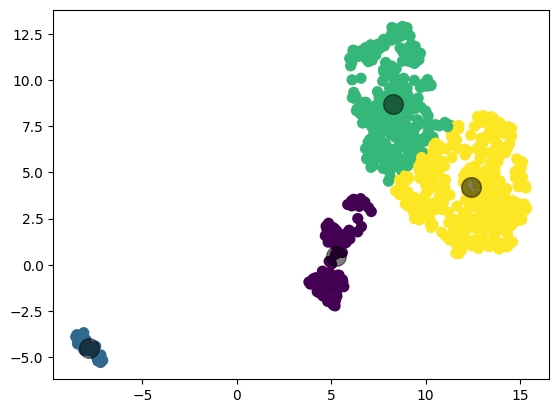

In [15]:
n_clusters=4  #The number of clusters to form as well as the number of centroids to generate
# Application of the model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_umap)
y_aniso = kmeans.predict(X_umap)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_aniso, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

Since this type of clustering is good for data that are well separated from each other, we faced both the advantage and disadvantage of this method. It clustered data that did not stick together well, but it had problems with data that were close together.

### 1.3. Gaussian mixture model
- Parameters: many
- Scalability: Not scalable
- Usecase: Flat geometry, good for density estimation, inductive
- Used metric: Mahalanobis distances to  centers

We chose the Gaussian Mixture Model as the second clustering model because it can handle data sets with clusters of different shape, size, and density, and it can also be used for data with a non-Gaussian distribution.


In [16]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariances_, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariances_.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariances_)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariances_)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    sns.set_style("white")
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\iyale\AppData\Local\Temp\ipykernel_5608\3880830143.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


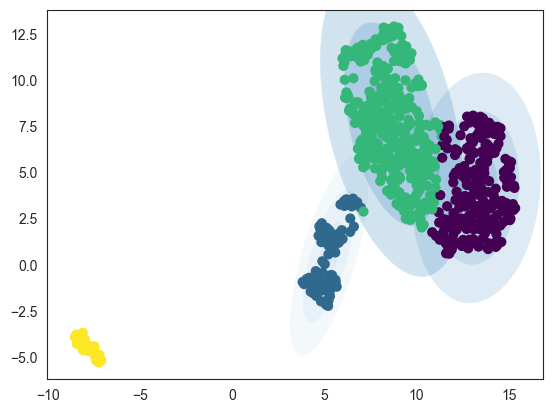

In [17]:
#Application of the clustering method
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=20).fit(X_umap)
labels = gmm.predict(X_umap)
plot_gmm(gmm, X_umap)

The data is divided into 4 clusters well, there is a slight overlap of the two clusters

## 2. Feature engineering
To generate new descriptors, we will choose descriptors that have a physical meaning, they were specified in the previous homework, they are very strongly correlated with each other, perhaps this method will allow them to be used more effectively

'MolWt', 'Volume3D', 'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex','HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons'

In [18]:
#Select the necessary parameters and divide the selection
X = df_norm.loc[:, ['MolWt', 'Volume3D', 'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex',
                    'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 
                    'NumValenceElectrons', 'XLogP']]
y = df_norm.loc[:, ['Refractive_index']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=360)

In [19]:
#AutoFeatRegressor was used to generate new descriptors
model = AutoFeatRegressor(apply_pi_theorem=True, categorical_cols=None,
          feateng_cols=None, feateng_steps=2, featsel_runs=3,
          transformations=('exp', 'log', 'abs', 'sqrt', '^2', '^3', '1/'),)
model

AutoFeatRegressor(featsel_runs=3,
                  transformations=('exp', 'log', 'abs', 'sqrt', '^2', '^3',
                                   '1/'))

In [20]:
#Application of the function
X_train_feature_creation = model.fit_transform(X_train.to_numpy(), y_train.to_numpy().flatten())
X_test_feature_creation = model.transform(X_test.to_numpy())

In [21]:
#Dataset with new parameters
X_test_feature_creation.head()

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,x000**2*x002,sqrt(x002)*x009,x001*sqrt(x007),sqrt(x004)*sqrt(x007),x004*x005**3,sqrt(x009)*exp(x004)
0,0.085480,0.329712,0.000294,0.481064,2.417795e-01,0.344186,0.021739,0.00,0.148936,0.137876,0.527811,0.000002,0.002363,0.000000,0.000000e+00,9.858238e-03,0.472877
1,0.138062,0.574041,0.000129,0.789069,9.930127e-02,0.609302,0.086957,0.00,0.085106,0.220285,0.401183,0.000002,0.002499,0.000000,0.000000e+00,2.246225e-02,0.518345
2,0.016727,0.045615,0.027486,0.147719,4.152550e-13,0.046512,0.021739,0.04,0.042553,0.026941,0.301775,0.000008,0.004467,0.009123,1.288806e-07,4.178299e-17,0.164138
3,0.033104,0.136430,0.001963,0.230595,6.824348e-01,0.116279,0.021739,0.00,0.021277,0.058637,0.402367,0.000002,0.002598,0.000000,0.000000e+00,1.072916e-03,0.479142
4,0.037638,0.293220,0.004101,0.624417,1.820555e-02,0.311628,0.065217,0.00,0.085106,0.036450,0.465089,0.000006,0.002334,0.000000,0.000000e+00,5.509509e-04,0.194427


In [22]:
#Dataset with new parameters
X_train_feature_creation.head()

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,x000**2*x002,sqrt(x002)*x009,x001*sqrt(x007),sqrt(x004)*sqrt(x007),x004*x005**3,sqrt(x009)*exp(x004)
0,0.118289,0.466307,0.000176,0.496428,2.126632e-01,0.465116,0.108696,0.08,0.148936,0.182250,0.461538,0.000002,0.002415,0.131892,1.304341e-01,2.139819e-02,0.528071
1,0.070404,0.329048,0.000345,0.409412,2.751557e-01,0.279070,0.021739,0.00,0.021277,0.125198,0.627219,0.000002,0.002326,0.000000,0.000000e+00,5.980216e-03,0.465905
2,0.034782,0.126685,0.005278,0.275556,4.194240e-01,0.093023,0.000000,0.00,0.021277,0.049128,0.502959,0.000006,0.003569,0.000000,0.000000e+00,3.376197e-04,0.337147
3,0.059323,0.223927,0.000585,0.292213,4.339193e-01,0.232558,0.065217,0.00,0.085106,0.096672,0.396450,0.000002,0.002337,0.000000,0.000000e+00,5.457624e-03,0.479843
4,0.025479,0.089363,0.002204,0.172743,7.457039e-13,0.093023,0.021739,0.04,0.042553,0.039620,0.366864,0.000001,0.001860,0.017873,1.727083e-07,6.002622e-16,0.199047


In order to make sure that the new descriptors really do not correlate with each other and can be used further, we will build a correlation matrix

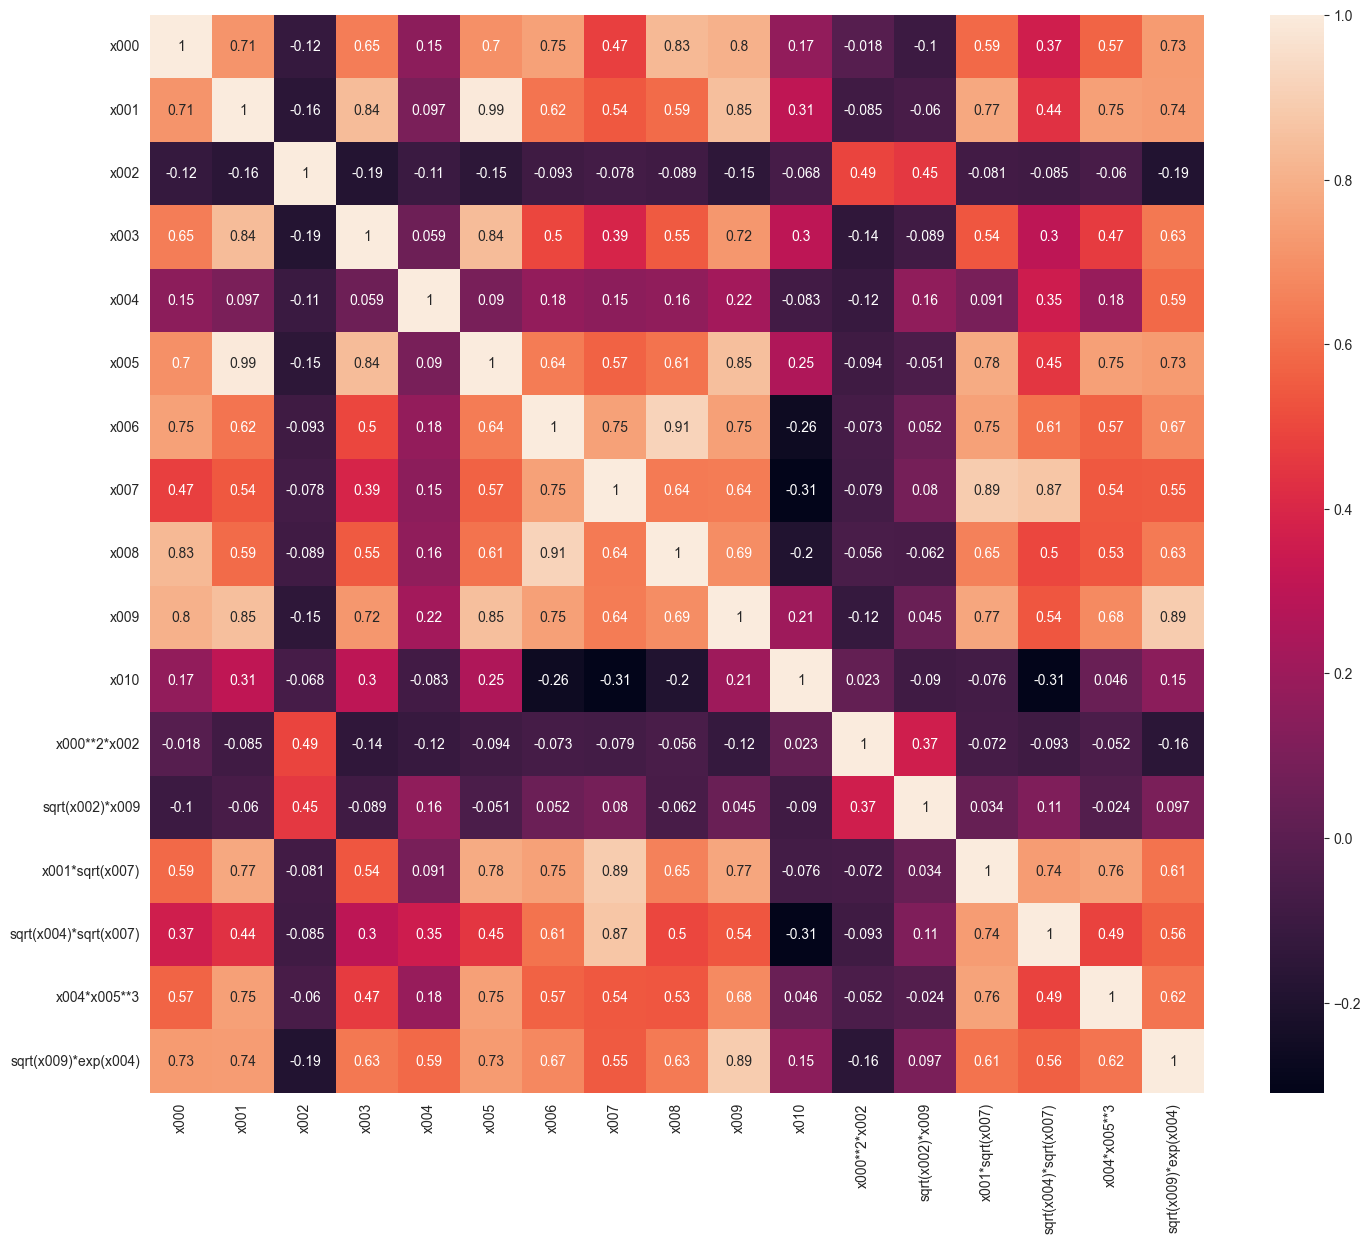

In [23]:
# construction of the correlation matrix
plt.figure(figsize=(17, 14))
corr = X_train_feature_creation.corr()

# visualization of the correlation matrix
plot = sns.heatmap(corr, annot=True)

It can be seen that the new descriptors have retained their chemical information and now do not correlate with each other

## 3. Feature selection
*GeneticSelectionCV* is an automatic feature selection method that uses genetic algorithms to determine the optimal set of features for a machine learning model. It is used to automate the feature selection process, which can take a lot of time and resources if done manually.


In [24]:
X, y = df_norm.drop(["Refractive_index"], axis=1), data_imputed[["Refractive_index"]].values.flatten()

estimator = RandomForestRegressor() #Regression

model = GeneticSelectionCV(
    estimator, cv=5, verbose=0,
    scoring="r2", max_features=77,
    n_population=10, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=777,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=20,
    caching=True, n_jobs=-1)

model = model.fit(X, y) #model training

In [25]:
# Important descriptors
print('Features:', X.columns[model.support_])

Features: Index(['measurement_error', 'MaxPartialCharge', 'BCUT2D_MWHI', 'Kappa3',
       'SMR_VSA9', 'SlogP_VSA12', 'NumAromaticRings', 'fr_Al_OH', 'fr_ArN',
       'fr_amidine', 'fr_piperdine', 'fr_sulfone', 'fr_term_acetylene',
       'InertialShapeFactor', 'IsotopeAtomCount', 'nH', 'ATS2dv', 'ATS7d',
       'ATS6p', 'ATS4i', 'ATSC4m', 'ATSC5i', 'AATSC0p', 'nBondsO', 'C2SP2',
       'Xc-4d', 'Xpc-4dv', 'Xp-2d', 'Xp-1dv', 'NssssB', 'NtCH', 'NsNH3',
       'NdNH', 'NsSH', 'NdssS', 'SsCH3', 'SdNH', 'SsssNH', 'SdsN', 'SaasN',
       'SsF', 'SsSiH3', 'SssS', 'ZMIC2', 'SMR_VSA5.1', 'SMR_VSA9.1',
       'SlogP_VSA3.1', 'SlogP_VSA8.1', 'VSA_EState2.1', 'MPC5', 'piPC6',
       'TpiPC10', 'bpol', 'n7AHRing', 'n9FRing', 'nFaRing', 'nFaHRing',
       'n9FaHRing', 'n8FARing', 'SRW07'],
      dtype='object')


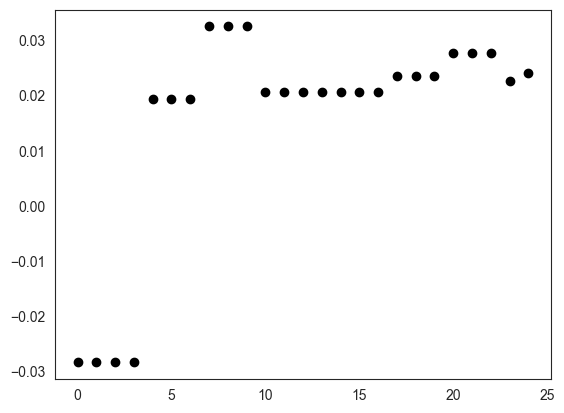

In [26]:
# Visualize
plt.plot(model.generation_scores_, 'o', color='black')

Приблизились к максимальному значению метрики 0.035, поэтому нельзя с точностью сказать, что выбранные дескрипторы важные.